# Hill Climbing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time # Will be used later for Monte Carlo

class HillClimbing:
    def __init__(self, num_jobs, num_machines, mean_time=4.0, minimo=2.0, maximo=15.0,
                 seed=None, verbose=False, enable_plotting=False, plot_interval=4):
        """
        Initializes the Hill Climbing solver for the Flow Shop Scheduling Problem.

        Args:
            num_jobs (int): Number of jobs.
            num_machines (int): Number of machines.
            mean_time (float): Mean processing time for random generation.
            minimo (float): Minimum processing time.
            maximo (float): Maximum processing time.
            seed (int, optional): Random seed for reproducibility. Defaults to None.
            verbose (bool, optional): If True, prints detailed execution steps. Defaults to False.
            enable_plotting (bool, optional): If True, enables Gantt chart plotting. Defaults to False.
            plot_interval (int, optional): Interval for plotting during search (if enabled). Defaults to 4.
        """
        self.num_jobs = num_jobs
        self.num_machines = num_machines
        self.mean_time = mean_time
        self.minimo = minimo
        self.maximo = maximo
        self.seed = seed
        self.verbose = verbose
        self.enable_plotting = enable_plotting # Plotting will be disabled for timing runs
        self.plot_interval = plot_interval # Not heavily used if plotting is generally off for timing

        if self.seed is not None:
            np.random.seed(self.seed)

    def _generar_matriz_aleatoria(self, num_filas, num_columnas):
        """
        Generates a random processing time matrix using Exponential distribution,
        clipped to [minimo, maximo].
        Uses instance attributes for mean_time, minimo, maximo.
        """
        matriz_tiempos = np.random.exponential(scale=self.mean_time, size=(num_filas, num_columnas))
        np.clip(matriz_tiempos, self.minimo, self.maximo, out=matriz_tiempos)
        return matriz_tiempos

    def _times_for_fitness(self, sol, tiempos_procesamiento):
        """
        Calculates the completion times for each job on each machine.
        'sol' is the sequence of job indices.
        'tiempos_procesamiento' is the matrix of processing times (job_idx, machine_idx).
        """
        num_trabajos_in_sol = len(sol)
        if num_trabajos_in_sol == 0:
            return np.array([[]]) # Or handle as an error/empty case

        _, num_maquinas_in_problem = tiempos_procesamiento.shape
        matriz_tiempos_completado = np.zeros((num_trabajos_in_sol, num_maquinas_in_problem), dtype=np.float32)

        for i, trabajo_idx in enumerate(sol): # trabajo_idx is the actual job number (e.g., from 0 to num_jobs-1)
            if trabajo_idx >= tiempos_procesamiento.shape[0]:
                raise ValueError(f"Job index {trabajo_idx} in solution is out of bounds for "
                                 f"tiempos_procesamiento with {tiempos_procesamiento.shape[0]} jobs.")

            for j in range(num_maquinas_in_problem):
                tiempo_proc_actual = tiempos_procesamiento[trabajo_idx, j]
                if i == 0 and j == 0: # First job in sequence, first machine
                    matriz_tiempos_completado[i, j] = tiempo_proc_actual
                elif i == 0: # First job in sequence, j-th machine
                    matriz_tiempos_completado[i, j] = matriz_tiempos_completado[i, j-1] + tiempo_proc_actual
                elif j == 0: # i-th job in sequence, first machine
                    matriz_tiempos_completado[i, j] = matriz_tiempos_completado[i-1, j] + tiempo_proc_actual
                else: # i-th job in sequence, j-th machine
                    matriz_tiempos_completado[i, j] = max(
                        matriz_tiempos_completado[i-1, j],
                        matriz_tiempos_completado[i, j-1]
                    ) + tiempo_proc_actual
        return matriz_tiempos_completado

    def _fitness(self, sol, tiempos_procesamiento):
        """
        Calculates makespan: completion time of the last job on the last machine.
        """
        if not sol: # Handle empty solution
            return float('inf')
        completion_times = self._times_for_fitness(sol, tiempos_procesamiento)
        return completion_times[-1, -1]

    def _get_neighbors(self, sol_list):
        """
        Generates neighbors by swapping pairs of jobs in the solution sequence.
        'sol_list' must be a list.
        """
        neighbors = []
        n = len(sol_list)
        for i in range(n - 1):
            for j in range(i + 1, n):
                new_sol_list = deepcopy(sol_list)
                new_sol_list[i], new_sol_list[j] = new_sol_list[j], new_sol_list[i]
                neighbors.append(new_sol_list)
        return neighbors

    def _plot_schedule(self, sol, tiempos_procesamiento, fitness_val, title_suffix, alpha=0.95):
        """Plots the Gantt chart for the given solution."""
        if not self.enable_plotting:
            return

        # Ensure matplotlib is available if plotting is enabled
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            if self.verbose:
                print("Matplotlib not found. Cannot plot schedule.")
            return

        matriz_tiempos_completado = self._times_for_fitness(sol, tiempos_procesamiento)
        num_maquinas = tiempos_procesamiento.shape[1]
        num_trabajos_in_sol = len(sol)

        fig, ax = plt.subplots(figsize=(10, max(6, num_maquinas * 0.5))) # Dynamic figure size
        
        # Check if sol is empty before trying to access job indices
        if not sol:
            if self.verbose:
                print("Cannot plot schedule for an empty solution.")
            return

        max_job_index_in_sol = max(sol) if sol else -1
        if max_job_index_in_sol >= tiempos_procesamiento.shape[0]:
            if self.verbose:
                print(f"Error plotting: Job index {max_job_index_in_sol} in solution is out of bounds "
                      f"for tiempos_procesamiento with {tiempos_procesamiento.shape[0]} jobs.")
            return

        for i, trabajo_idx in enumerate(sol):
            for j in range(num_maquinas):
                inicio = matriz_tiempos_completado[i, j] - tiempos_procesamiento[trabajo_idx, j]
                duracion = tiempos_procesamiento[trabajo_idx, j]
                # Use modulo for C{i} to avoid running out of default colors for many jobs
                ax.barh(y=j, width=duracion, left=inicio,
                        color=f"C{trabajo_idx % 10}", edgecolor="black", alpha=alpha)
                ax.text(inicio + duracion/2, j, f"J{trabajo_idx}",
                        va="center", ha="center", color="white", fontsize=8, fontweight='bold')
        ax.set_xlabel("Tiempo")
        ax.set_ylabel("Máquinas")
        ax.set_title(f"Schedule: {num_trabajos_in_sol} Jobs, {num_maquinas} Machines - {title_suffix} (Makespan={fitness_val:.2f})")
        ax.set_yticks(range(num_maquinas))
        ax.set_yticklabels([f"M{k}" for k in range(num_maquinas)])
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def _perform_hill_climbing(self, initial_solution_list, tiempos_procesamiento):
        """
        Core Hill Climbing algorithm logic.
        'initial_solution_list' must be a list.
        """
        current_solution = list(initial_solution_list) # Work with a copy
        current_fitness = self._fitness(current_solution, tiempos_procesamiento)

        if self.verbose:
            print(f"HC Initial solution: {current_solution} - Fitness: {current_fitness:.2f}")

        iteration_count = 0
        while True:
            if self.verbose:
                 print(f"HC Iteration: {iteration_count}")

            neighbors = self._get_neighbors(current_solution)
            if not neighbors: # Should only happen if len(current_solution) < 2
                if self.verbose:
                    print("HC: No neighbors could be generated.")
                break

            best_neighbor = None
            # Initialize with current fitness, as we are looking for strict improvement
            best_neighbor_fitness = current_fitness

            # Iterate through neighbors to find the one with the greatest improvement
            # This is a "steepest ascent" hill climbing variant.
            # The original code picked the first better neighbor if multiple had same best fitness.
            # min(neighbors, key=lambda s: self._fitness(s, tiempos_procesamiento)) does this efficiently.
            
            temp_best_neighbor = current_solution # Placeholder
            temp_best_neighbor_fitness = current_fitness

            for neighbor in neighbors:
                neighbor_fitness = self._fitness(neighbor, tiempos_procesamiento)
                if neighbor_fitness < temp_best_neighbor_fitness:
                    temp_best_neighbor_fitness = neighbor_fitness
                    temp_best_neighbor = neighbor
            
            # If a strictly better neighbor was found
            if temp_best_neighbor_fitness < current_fitness:
                current_solution = temp_best_neighbor
                current_fitness = temp_best_neighbor_fitness
                if self.verbose:
                    print(f"HC Improvement: New Best Fitness = {current_fitness:.2f} with solution {current_solution}")
            else:
                # No better neighbor found, local optimum reached
                if self.verbose:
                    print(f"HC: No improvement found. Current fitness {current_fitness:.2f}. Local optimum reached.")
                break
            iteration_count += 1
        
        if self.verbose:
            print(f"HC finished after {iteration_count} iterations.")
        return current_solution, current_fitness

    def solve(self, tiempos_procesamiento=None, initial_solution_list=None):
        """
        Executes the Hill Climbing algorithm for a flow-shop problem.

        Args:
            tiempos_procesamiento (np.array, optional): Pre-generated processing times matrix.
                If None, it's generated based on instance parameters. Shape (num_jobs, num_machines).
            initial_solution_list (list, optional): A specific initial sequence of job indices.
                If None, a random solution is generated.

        Returns:
            tuple: (optimal_solution_list, optimal_fitness)
        """
        if self.seed is not None:
            np.random.seed(self.seed) # Ensure seeding if new data/solution is generated here

        if tiempos_procesamiento is None:
            # Use instance's num_jobs, num_machines for generation
            tp = self._generar_matriz_aleatoria(self.num_jobs, self.num_machines)
            current_num_jobs_for_sol = self.num_jobs
        else:
            tp = tiempos_procesamiento
            current_num_jobs_for_sol = tp.shape[0] # num_jobs derived from the provided matrix

        if self.verbose:
            print(f"--- Hill Climbing Execution (Jobs: {current_num_jobs_for_sol}, Machines: {tp.shape[1]}) ---")
            # print("Processing Times Matrix (HC):")
            # print(tp) # Can be very large, so usually commented out

        if initial_solution_list is None:
            sol0_list = list(np.arange(current_num_jobs_for_sol))
            np.random.shuffle(sol0_list)
        else:
            # Ensure it's a list and a copy, and matches the number of jobs in tp
            if len(initial_solution_list) != current_num_jobs_for_sol:
                raise ValueError(f"Provided initial_solution_list length ({len(initial_solution_list)}) "
                                 f"does not match number of jobs in tiempos_procesamiento ({current_num_jobs_for_sol}).")
            sol0_list = list(initial_solution_list)


        initial_fitness = self._fitness(sol0_list, tp)
        if self.verbose:
            print(f"Initial Solution (HC): {sol0_list}, Fitness: {initial_fitness:.2f}")

        if self.enable_plotting:
            self._plot_schedule(sol0_list, tp, initial_fitness, "HC Initial")

        # Core algorithm execution
        optimal_solution_list, optimal_fitness = self._perform_hill_climbing(sol0_list, tp)

        if self.verbose:
            print(f"Optimal Solution (HC): {optimal_solution_list}, Optimal Fitness: {optimal_fitness:.2f}")

        if self.enable_plotting:
            self._plot_schedule(optimal_solution_list, tp, optimal_fitness, "HC Optimal")
        
        if self.verbose:
            print("--- End of Hill Climbing Execution ---")
            
        return optimal_solution_list, optimal_fitness


    

In [ ]:
hc_solver_verbose = HillClimbing(
        num_jobs=4,
        num_machines=30,
        mean_time=4.0,
        minimo=1.0,
        maximo=20.0,
        seed=42,
        verbose=True,
        enable_plotting=True
    )
print("Running Hill Climbing with verbose output and plotting:")
# Solver generates its own processing times and initial solution
solution, fitness = hc_solver_verbose.solve()
print(f"\nFinal HC (verbose run) -> Solution: {solution}, Fitness: {fitness:.2f}\n")


In [ ]:
num_j = 6
num_m = 4

hc_solver_timing = HillClimbing(
        num_jobs=num_j, # Used if tp not provided to solve()
        num_machines=num_m, # Used if tp not provided to solve()
        verbose=False,
        enable_plotting=False
    )

print("Simulating a scenario for timing (verbose/plotting off):")

np.random.seed(42)
example_tiempos = hc_solver_timing._generar_matriz_aleatoria(num_j, num_m)

example_initial_sol = list(np.arange(num_j))
np.random.shuffle(example_initial_sol)

print(f"Example processing times for {num_j} jobs, {num_m} machines:\n{example_tiempos}")
print(f"Example initial solution: {example_initial_sol}")

start_time = time.perf_counter()
best_sol, best_fit = hc_solver_timing.solve(
    tiempos_procesamiento=example_tiempos,
    initial_solution_list=example_initial_sol
)
end_time = time.perf_counter()

print(f"HC solution: {best_sol}, Fitness: {best_fit:.2f}")
print(f"HC execution time for this instance: {end_time - start_time:.6f} seconds")

Simulating a scenario for timing (verbose/plotting off):
Example processing times for 6 jobs, 4 machines:
[[ 2.         12.04048572  5.26698277  3.65177022]
 [ 2.          2.          2.          8.04492346]
 [ 3.67632861  4.92500025  2.         14.0142299 ]
 [ 7.14571817  2.          2.          2.        ]
 [ 2.          2.97571132  2.26214827  2.        ]
 [ 3.7854835   2.          2.          2.        ]]
Example initial solution: [np.int64(0), np.int64(1), np.int64(4), np.int64(3), np.int64(2), np.int64(5)]
HC solution: [np.int64(1), np.int64(2), np.int64(0), np.int64(3), np.int64(4), np.int64(5)], Fitness: 37.71
HC execution time for this instance: 0.001993 seconds


# Simulated Annealing

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time

class SimulatedAnnealing:
    def __init__(self, num_jobs, num_machines,
                 T_max, T_min, cooling_rate,
                 mean_time=4.0, minimo=2.0, maximo=15.0,
                 seed=None, verbose=False, enable_plotting=False):
        """
        Initializes the Simulated Annealing solver for the Flow Shop Scheduling Problem.

        Args:
            num_jobs (int): Number of jobs.
            num_machines (int): Number of machines.
            T_max (float): Initial maximum temperature.
            T_min (float): Minimum temperature to stop.
            cooling_rate (float): Cooling rate (e.g., 0.95, 0.99).
            mean_time (float): Mean processing time for random generation.
            minimo (float): Minimum processing time.
            maximo (float): Maximum processing time.
            seed (int, optional): Random seed for reproducibility. Defaults to None.
            verbose (bool, optional): If True, prints detailed execution steps. Defaults to False.
            enable_plotting (bool, optional): If True, enables Gantt chart plotting. Defaults to False.
        """
        self.num_jobs = num_jobs
        self.num_machines = num_machines
        self.mean_time = mean_time
        self.minimo = minimo
        self.maximo = maximo
        self.seed = seed
        self.verbose = verbose
        self.enable_plotting = enable_plotting # Plotting will be disabled for timing runs

        # SA specific parameters
        self.T_max = T_max
        self.T_min = T_min
        self.cooling_rate = cooling_rate

        if self.seed is not None:
            np.random.seed(self.seed)

    # --- Common methods (could be refactored into a base class or utility module later) ---
    def _generar_matriz_aleatoria(self, num_filas, num_columnas):
        """
        Generates a random processing time matrix using Exponential distribution,
        clipped to [minimo, maximo].
        Uses instance attributes for mean_time, minimo, maximo.
        """
        matriz_tiempos = np.random.exponential(scale=self.mean_time, size=(num_filas, num_columnas))
        np.clip(matriz_tiempos, self.minimo, self.maximo, out=matriz_tiempos)
        return matriz_tiempos

    def _times_for_fitness(self, sol, tiempos_procesamiento):
        """
        Calculates the completion times for each job on each machine.
        'sol' is the sequence of job indices (can be list or 1D NumPy array).
        'tiempos_procesamiento' is the matrix of processing times (job_idx, machine_idx).
        """
        num_trabajos_in_sol = len(sol)
        if num_trabajos_in_sol == 0:
            return np.array([[]])

        _, num_maquinas_in_problem = tiempos_procesamiento.shape
        matriz_tiempos_completado = np.zeros((num_trabajos_in_sol, num_maquinas_in_problem), dtype=np.float32)

        for i, trabajo_idx in enumerate(sol):
            if trabajo_idx >= tiempos_procesamiento.shape[0]:
                raise ValueError(f"Job index {trabajo_idx} in solution is out of bounds for "
                                 f"tiempos_procesamiento with {tiempos_procesamiento.shape[0]} jobs.")
            for j in range(num_maquinas_in_problem):
                tiempo_proc_actual = tiempos_procesamiento[trabajo_idx, j]
                if i == 0 and j == 0:
                    matriz_tiempos_completado[i, j] = tiempo_proc_actual
                elif i == 0:
                    matriz_tiempos_completado[i, j] = matriz_tiempos_completado[i, j-1] + tiempo_proc_actual
                elif j == 0:
                    matriz_tiempos_completado[i, j] = matriz_tiempos_completado[i-1, j] + tiempo_proc_actual
                else:
                    matriz_tiempos_completado[i, j] = max(
                        matriz_tiempos_completado[i-1, j],
                        matriz_tiempos_completado[i, j-1]
                    ) + tiempo_proc_actual
        return matriz_tiempos_completado

    def _fitness(self, sol, tiempos_procesamiento):
        """
        Calculates makespan: completion time of the last job on the last machine.
        """
        if not len(sol): # Works for empty list or numpy array
            return float('inf')
        completion_times = self._times_for_fitness(sol, tiempos_procesamiento)
        return completion_times[-1, -1]

    def _plot_schedule(self, sol, tiempos_procesamiento, fitness_val, title_suffix, alpha=0.95):
        """Plots the Gantt chart for the given solution."""
        if not self.enable_plotting:
            return

        try:
            import matplotlib.pyplot as plt
        except ImportError:
            if self.verbose:
                print("Matplotlib not found. Cannot plot schedule.")
            return

        matriz_tiempos_completado = self._times_for_fitness(sol, tiempos_procesamiento)
        num_maquinas = tiempos_procesamiento.shape[1]
        num_trabajos_in_sol = len(sol)

        fig, ax = plt.subplots(figsize=(10, max(6, num_maquinas * 0.5)))
        
        if not sol if isinstance(sol, list) else not sol.size: # Check for empty Python list or NumPy array
             if self.verbose:
                print("Cannot plot schedule for an empty solution.")
             return

        max_job_index_in_sol = np.max(sol) if len(sol) > 0 else -1
        if max_job_index_in_sol >= tiempos_procesamiento.shape[0]:
            if self.verbose:
                print(f"Error plotting: Job index {max_job_index_in_sol} in solution is out of bounds "
                      f"for tiempos_procesamiento with {tiempos_procesamiento.shape[0]} jobs.")
            return

        for i, trabajo_idx in enumerate(sol):
            for j in range(num_maquinas):
                inicio = matriz_tiempos_completado[i, j] - tiempos_procesamiento[trabajo_idx, j]
                duracion = tiempos_procesamiento[trabajo_idx, j]
                ax.barh(y=j, width=duracion, left=inicio,
                        color=f"C{trabajo_idx % 10}", edgecolor="black", alpha=alpha)
                ax.text(inicio + duracion/2, j, f"J{trabajo_idx}",
                        va="center", ha="center", color="white", fontsize=8, fontweight='bold')
        ax.set_xlabel("Tiempo")
        ax.set_ylabel("Máquinas")
        ax.set_title(f"Simulated Annealing: {num_trabajos_in_sol}J, {num_maquinas}M - {title_suffix} (Makespan={fitness_val:.2f})")
        ax.set_yticks(range(num_maquinas))
        ax.set_yticklabels([f"M{k}" for k in range(num_maquinas)])
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # --- SA specific methods ---
    def _random_neighbor(self, sol_array):
        """
        Generates a random neighbor by swapping two elements in the solution (NumPy array).
        """
        if len(sol_array) < 2: # Not enough elements to swap
            return sol_array.copy()

        i, j = np.random.choice(len(sol_array), 2, replace=False)
        new_sol_array = sol_array.copy() # Ensure it's a copy
        new_sol_array[i], new_sol_array[j] = new_sol_array[j], new_sol_array[i]
        return new_sol_array

    def _accept_probability(self, delta_energy, temperature):
        """
        Determines if a worse solution is accepted based on temperature (Metropolis criterion).
        """
        if delta_energy < 0:  # New solution is better, always accept
            return True
        if temperature <= 1e-9: # Effectively zero temperature, avoid division by zero / overflow
            return False
        # New solution is worse, accept with a probability
        return np.random.rand() < np.exp(-delta_energy / temperature)

    def _perform_simulated_annealing(self, initial_solution_array, tiempos_procesamiento):
        """Core Simulated Annealing algorithm logic."""
        current_temp = self.T_max
        # Ensure current_solution is a NumPy array for SA operations
        current_solution = np.array(initial_solution_array, dtype=int).copy()
        current_fitness = self._fitness(current_solution, tiempos_procesamiento)

        # SA needs to keep track of the best solution found globally
        best_solution_so_far = current_solution.copy()
        best_fitness_so_far = current_fitness

        if self.verbose:
            # .tolist() for cleaner printing of numpy arrays
            print(f"SA Initial solution: {current_solution.tolist()} - Fitness: {current_fitness:.2f} at T={current_temp:.2f}")

        iteration_count = 0
        # Loop while temperature is above minimum
        while current_temp > self.T_min:
            if self.verbose and iteration_count % 200 == 0: # Adjust print frequency as needed
                 print(f"SA Iter: {iteration_count}, Temp: {current_temp:.4g}, Fitness: {current_fitness:.2f}, Best: {best_fitness_so_far:.2f}")

            neighbor_solution = self._random_neighbor(current_solution)
            neighbor_fitness = self._fitness(neighbor_solution, tiempos_procesamiento)

            delta_energy = neighbor_fitness - current_fitness

            if self._accept_probability(delta_energy, current_temp):
                current_solution = neighbor_solution # .copy() already done in _random_neighbor
                current_fitness = neighbor_fitness

                # Update the best-so-far solution if the accepted one is better
                if current_fitness < best_fitness_so_far:
                    best_solution_so_far = current_solution.copy() # Make a new copy for best
                    best_fitness_so_far = current_fitness
                    if self.verbose:
                        print(f"SA New Global Best: Fitness = {best_fitness_so_far:.2f} with {best_solution_so_far.tolist()} at T={current_temp:.4g}")
            
            current_temp *= self.cooling_rate  # Cool down
            iteration_count += 1
        
        if self.verbose:
            print(f"SA finished after {iteration_count} iterations. Final Temp: {current_temp:.4g}")
            print(f"SA Best solution found: {best_solution_so_far.tolist()} - Fitness: {best_fitness_so_far:.2f}")
        
        # Return the best solution found during the entire process
        return best_solution_so_far.tolist(), best_fitness_so_far


    def solve(self, tiempos_procesamiento=None, initial_solution=None):
        """
        Executes the Simulated Annealing algorithm for a flow-shop problem.

        Args:
            tiempos_procesamiento (np.array, optional): Pre-generated processing times matrix.
                If None, it's generated based on instance parameters. Shape (num_jobs, num_machines).
            initial_solution (list or np.array, optional): A specific initial sequence of job indices.
                If None, a random solution is generated. Will be converted to a NumPy array.

        Returns:
            tuple: (optimal_solution_list, optimal_fitness) - solution is returned as a list.
        """
        if self.seed is not None:
            np.random.seed(self.seed) # Ensure seeding for SA's internal randomness

        if tiempos_procesamiento is None:
            tp = self._generar_matriz_aleatoria(self.num_jobs, self.num_machines)
            current_num_jobs_for_sol = self.num_jobs
        else:
            tp = tiempos_procesamiento
            current_num_jobs_for_sol = tp.shape[0]

        if self.verbose:
            print(f"--- Simulated Annealing Execution (Jobs: {current_num_jobs_for_sol}, Machines: {tp.shape[1]}) ---")
            # print("Processing Times Matrix (SA):"); # print(tp)

        if initial_solution is None:
            # SA internally prefers NumPy arrays
            sol0_array = np.arange(current_num_jobs_for_sol, dtype=int)
            np.random.shuffle(sol0_array)
        else:
            # Convert to NumPy array if it's a list, and ensure it's a copy.
            # Also ensure dtype is int for indexing.
            if len(initial_solution) != current_num_jobs_for_sol:
                raise ValueError(f"Provided initial_solution length ({len(initial_solution)}) "
                                 f"does not match number of jobs in tiempos_procesamiento ({current_num_jobs_for_sol}).")
            sol0_array = np.array(initial_solution, dtype=int).copy()


        initial_fitness = self._fitness(sol0_array, tp)
        if self.verbose:
            print(f"Initial Solution (SA): {sol0_array.tolist()}, Fitness: {initial_fitness:.2f}")

        if self.enable_plotting:
            self._plot_schedule(sol0_array, tp, initial_fitness, "SA Initial")

        # Core algorithm execution
        optimal_solution_array, optimal_fitness = self._perform_simulated_annealing(sol0_array, tp)

        if self.verbose:
            # optimal_solution_array is already a list from _perform_simulated_annealing
            print(f"Optimal Solution (SA): {optimal_solution_array}, Optimal Fitness: {optimal_fitness:.2f}")

        if self.enable_plotting:
            self._plot_schedule(optimal_solution_array, tp, optimal_fitness, "SA Optimal")
        
        if self.verbose:
             print("--- End of Simulated Annealing Execution ---")
             
        # Return solution as a list for consistency with HillClimbingFSSP output
        return list(optimal_solution_array), optimal_fitness

In [ ]:
sa_solver_verbose = SimulatedAnnealing(
        num_jobs=5,
        num_machines=3,
        T_max=1000,
        T_min=0.01, # Adjusted T_min for faster example
        cooling_rate=0.90, # Adjusted cooling_rate for faster example
        mean_time=10.0,
        minimo=1.0,
        maximo=20.0,
        seed=42,
        verbose=True,
        enable_plotting=True
    )
print("Running Simulated Annealing with verbose output and plotting:")
# Solver generates its own processing times and initial solution
solution_sa, fitness_sa = sa_solver_verbose.solve()
print(f"\nFinal SA (verbose run) -> Solution: {solution_sa}, Fitness: {fitness_sa:.2f}\n")


In [36]:
num_j_mc = 6
num_m_mc = 4


sa_solver_timing = SimulatedAnnealing(
    num_jobs=num_j_mc, # Used if tp not provided to solve()
    num_machines=num_m_mc, # Used if tp not provided to solve()
    T_max=500, T_min=0.001, cooling_rate=0.95, # Example SA params
    verbose=False,
    enable_plotting=False,
    seed=123 # Seed for SA's internal randomness (like accept probability)
)

print("Simulating a scenario for SA timing (verbose/plotting off):")

np.random.seed(123) # Seed for problem generation
example_tiempos_sa = sa_solver_timing._generar_matriz_aleatoria(num_j_mc, num_m_mc)

# Generate initial solution (can also be seeded for consistency)
np.random.seed(456) # Seed for initial solution generation
example_initial_sol_sa = list(np.arange(num_j_mc))
np.random.shuffle(example_initial_sol_sa)

print(f"Example processing times for {num_j_mc} jobs, {num_m_mc} machines:\n{example_tiempos_sa}")
print(f"Example initial solution: {example_initial_sol_sa}")


start_time_sa = time.perf_counter()
best_sol_sa, best_fit_sa = sa_solver_timing.solve(
    tiempos_procesamiento=example_tiempos_sa,
    initial_solution=example_initial_sol_sa # Pass as list or array
)
end_time_sa = time.perf_counter()

print(f"SA solution: {best_sol_sa}, Fitness: {best_fit_sa:.2f}")
print(f"SA execution time for this instance: {end_time_sa - start_time_sa:.6f} seconds")

Simulating a scenario for SA timing (verbose/plotting off):
Example processing times for 6 jobs, 4 machines:
[[ 4.76908857  2.          2.          3.20573473]
 [ 5.08428374  2.20039014 15.          4.6185691 ]
 [ 2.62288077  2.          2.          5.22327959]
 [ 2.30908871  2.          2.0302854   5.35757296]
 [ 2.          2.          3.03331536  3.03567459]
 [ 4.02487225  7.57335641  5.15602201  3.7769455 ]]
Example initial solution: [np.int64(0), np.int64(4), np.int64(2), np.int64(1), np.int64(5), np.int64(3)]
SA solution: [4, 2, 3, 1, 0, 5], Fitness: 40.82
SA execution time for this instance: 0.010871 seconds


# Monte Carlo simulation

Starting Monte Carlo Simulation...

Running for configuration: Jobs=5, Machines=10
  ... completed run 500/1000 for J=5, M=10
  ... completed run 1000/1000 for J=5, M=10
Running for configuration: Jobs=5, Machines=30
  ... completed run 500/1000 for J=5, M=30
  ... completed run 1000/1000 for J=5, M=30
Running for configuration: Jobs=5, Machines=60
  ... completed run 500/1000 for J=5, M=60
  ... completed run 1000/1000 for J=5, M=60
Running for configuration: Jobs=10, Machines=10
  ... completed run 500/1000 for J=10, M=10
  ... completed run 1000/1000 for J=10, M=10
Running for configuration: Jobs=10, Machines=30
  ... completed run 500/1000 for J=10, M=30
  ... completed run 1000/1000 for J=10, M=30
Running for configuration: Jobs=10, Machines=60
  ... completed run 500/1000 for J=10, M=60
  ... completed run 1000/1000 for J=10, M=60
Running for configuration: Jobs=15, Machines=10
  ... completed run 500/1000 for J=15, M=10
  ... completed run 1000/1000 for J=15, M=10
Running for co

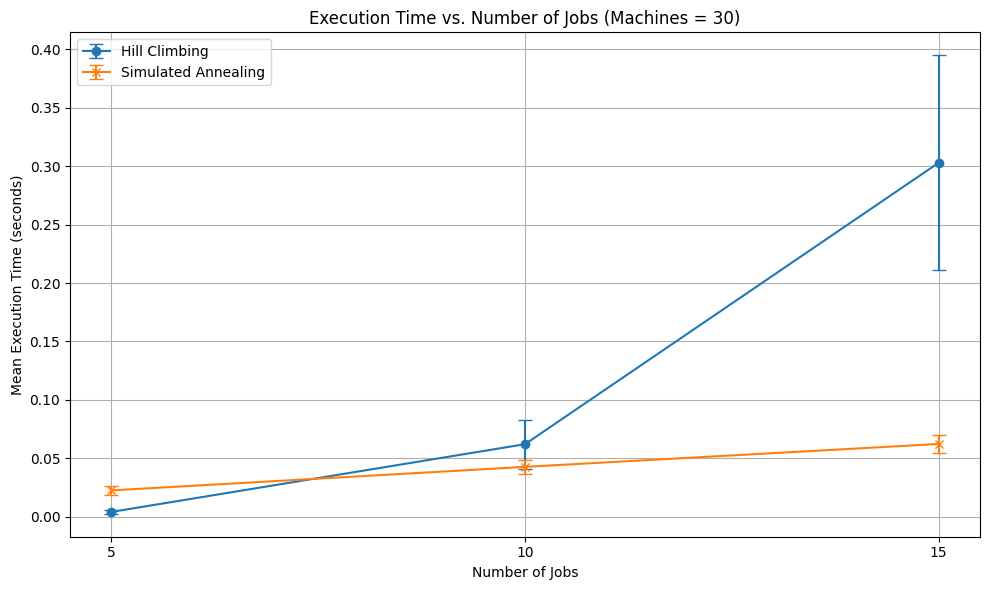

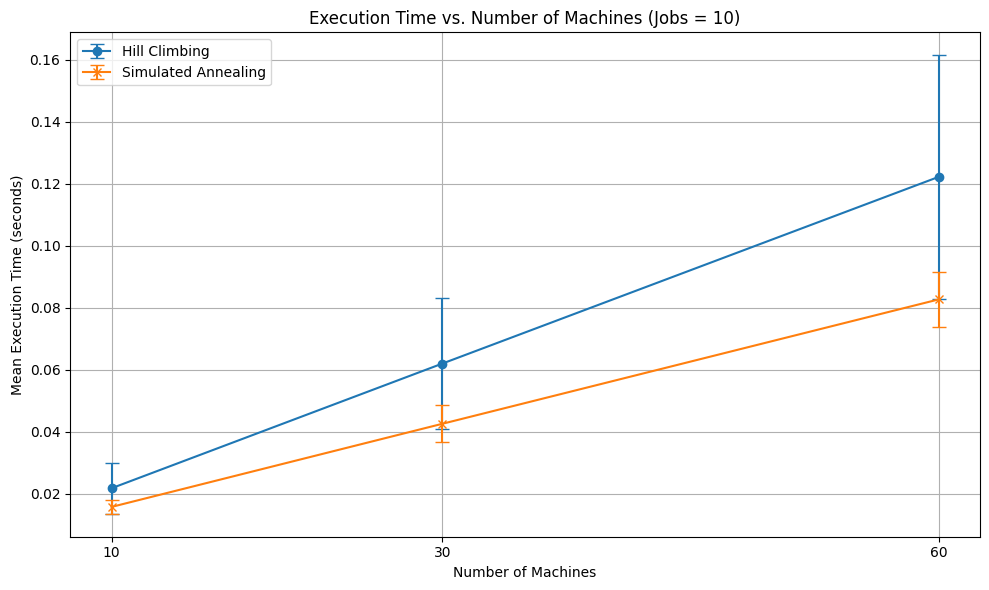


--- Analysis of Fitness (Makespan) ---
   Jobs  Machines HC Mean Fitness HC Std Fitness SA Mean Fitness SA Std Fitness
0     5        10          158.87          19.34          157.25          18.95
1     5        30          383.06          28.40          381.24          27.80
2     5        60          701.15          36.21          698.35          35.52
3    10        10          216.17          19.35          218.53          18.63
4    10        30          463.89          23.42          467.80          22.82
5    10        60          806.86          31.83          812.17          31.22
6    15        10          269.08          19.89          279.13          19.57
7    15        30          537.57          24.09          552.42          23.50
8    15        60          899.31          29.72          918.93          28.84

Done with all simulations and plotting.


In [ ]:
import pandas as pd
# --- Monte Carlo Simulation Setup ---

# Problem generation parameters (consistent for all runs)
COMMON_MEAN_TIME = 10.0
COMMON_MINIMO = 2.0
COMMON_MAXIMO = 25.0

def generate_problem_instance(num_jobs, num_machines, problem_seed):
    """Generates a problem instance (processing times and initial solution)."""
    np.random.seed(problem_seed) # Seed for this specific problem instance

    # Generate processing times
    tiempos = np.random.exponential(scale=COMMON_MEAN_TIME, size=(num_jobs, num_machines))
    np.clip(tiempos, COMMON_MINIMO, COMMON_MAXIMO, out=tiempos)

    # Generate initial solution (as a list)
    initial_sol = list(np.arange(num_jobs))
    np.random.shuffle(initial_sol)

    return tiempos, initial_sol

# Monte Carlo parameters
NUM_MONTE_CARLO_RUNS = 1000  # Number of runs for each parameter configuration (reduce for quick tests, increase for accuracy)
LIST_NUM_JOBS = [5, 10, 15] # Varying number of jobs
LIST_NUM_MACHINES = [10, 30, 60] # Varying number of machines

# SA parameters (fixed for this comparison)
SA_T_MAX = 1000
SA_T_MIN = 0.1
SA_COOLING_RATE = 0.95 # Faster cooling for quicker runs; for quality, 0.99 or 0.995 might be better

# Store results
# results[algorithm_name][(num_jobs, num_machines)] = [list_of_times]
results = {
    'hc': {},
    'sa': {}
}
results_fitness = { # To optionally store fitness values
    'hc': {},
    'sa': {}
}


# --- Main Simulation Loop ---
print("Starting Monte Carlo Simulation...\n")

for n_jobs in LIST_NUM_JOBS:
    for n_machines in LIST_NUM_MACHINES:
        config_key = (n_jobs, n_machines)
        print(f"Running for configuration: Jobs={n_jobs}, Machines={n_machines}")

        hc_times_for_config = []
        sa_times_for_config = []
        hc_fitness_for_config = []
        sa_fitness_for_config = []

        # Instantiate solvers once per configuration if their __init__ doesn't depend on per-run seeds
        # Pass seed=None so they use the global numpy seed set for each MC run.
        hc_solver = HillClimbing(num_jobs=n_jobs, num_machines=n_machines, verbose=False, enable_plotting=False, seed=None)
        sa_solver = SimulatedAnnealing(num_jobs=n_jobs, num_machines=n_machines,
                                           T_max=SA_T_MAX, T_min=SA_T_MIN, cooling_rate=SA_COOLING_RATE,
                                           verbose=False, enable_plotting=False, seed=None)

        for i_run in range(NUM_MONTE_CARLO_RUNS):
            # Generate a unique problem instance for this run using a unique seed
            # The seed for np.random is set inside generate_problem_instance
            problem_instance_seed = n_jobs * 1000 + n_machines * 100 + i_run # Just an example of unique seed
            current_tiempos, current_initial_sol = generate_problem_instance(n_jobs, n_machines, problem_instance_seed)

            # Time Hill Climbing
            start_time_hc = time.perf_counter()
            hc_sol, hc_fit = hc_solver.solve(tiempos_procesamiento=deepcopy(current_tiempos), # Pass copies
                                             initial_solution_list=deepcopy(current_initial_sol))
            end_time_hc = time.perf_counter()
            hc_times_for_config.append(end_time_hc - start_time_hc)
            hc_fitness_for_config.append(hc_fit)

            # Time Simulated Annealing
            # SA needs its own distinct random path for each run if its internal seed is None
            # which is achieved by generate_problem_instance reseeding np.random globally
            # If we wanted SA to be *more* deterministic on the *same problem instance across MC runs*,
            # we'd set sa_solver.seed to a fixed value. But here, we want it to explore.
            # The current setup: global seed is set by generate_problem_instance for problem creation.
            # Then SA solver (with seed=None) uses this global state for its internal randomness.
            # This means for the *same* problem_instance_seed, SA will have the *same* path.
            # This is good for comparing HC vs SA on that specific (problem_seed)-generated scenario.

            start_time_sa = time.perf_counter()
            sa_sol, sa_fit = sa_solver.solve(tiempos_procesamiento=deepcopy(current_tiempos), # Pass copies
                                             initial_solution=deepcopy(current_initial_sol))
            end_time_sa = time.perf_counter()
            sa_times_for_config.append(end_time_sa - start_time_sa)
            sa_fitness_for_config.append(sa_fit)

            if (i_run + 1) % (NUM_MONTE_CARLO_RUNS // 2 if NUM_MONTE_CARLO_RUNS >=2 else 1) == 0 : # Progress update
                 print(f"  ... completed run {i_run+1}/{NUM_MONTE_CARLO_RUNS} for J={n_jobs}, M={n_machines}")


        results['hc'][config_key] = hc_times_for_config
        results['sa'][config_key] = sa_times_for_config
        results_fitness['hc'][config_key] = hc_fitness_for_config
        results_fitness['sa'][config_key] = sa_fitness_for_config

print("\nMonte Carlo Simulation Finished.\n")

# --- Process and Print Results ---
print("--- Mean Execution Times (seconds) ---")
output_data = []
for n_j in LIST_NUM_JOBS:
    for n_m in LIST_NUM_MACHINES:
        config = (n_j, n_m)
        if config in results['hc'] and config in results['sa']:
            mean_hc_time = np.mean(results['hc'][config])
            std_hc_time = np.std(results['hc'][config])
            mean_sa_time = np.mean(results['sa'][config])
            std_sa_time = np.std(results['sa'][config])
            output_data.append({
                "Jobs": n_j, "Machines": n_m,
                "HC Mean Time (s)": f"{mean_hc_time:.4f}",
                "HC Std Dev (s)": f"{std_hc_time:.4f}",
                "SA Mean Time (s)": f"{mean_sa_time:.4f}",
                "SA Std Dev (s)": f"{std_sa_time:.4f}"
            })

df_results = pd.DataFrame(output_data)
print(df_results.to_string())
print("\n")



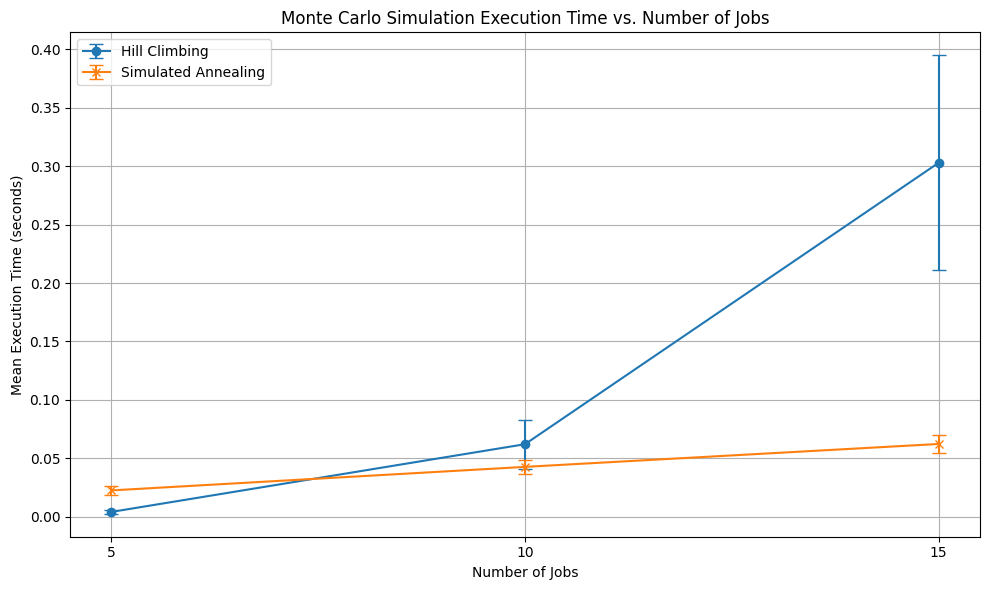

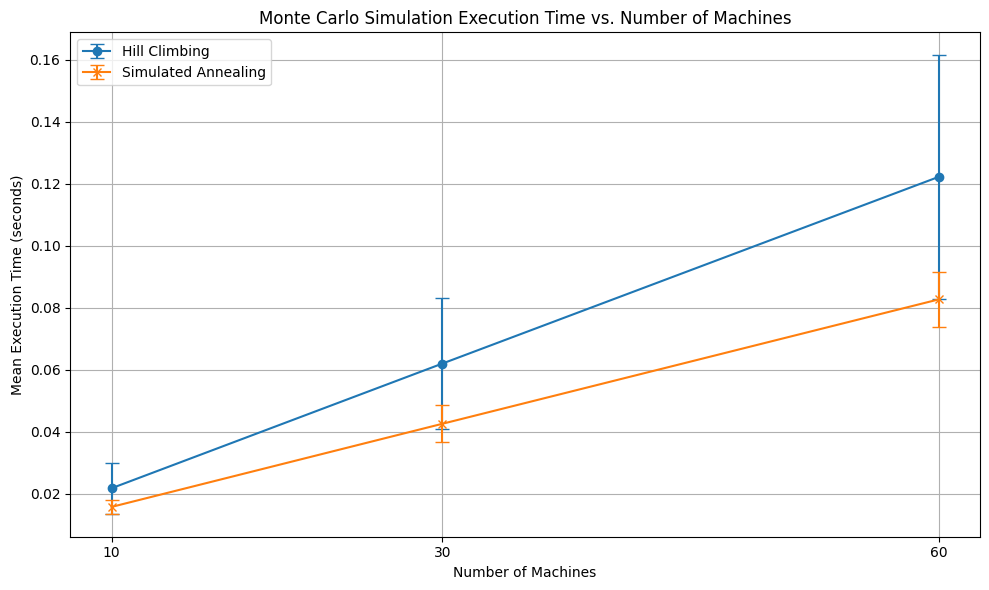


--- Analysis of Fitness (Makespan) ---
   Jobs  Machines HC Mean Fitness HC Std Fitness SA Mean Fitness SA Std Fitness
0     5        10          158.87          19.34          157.25          18.95
1     5        30          383.06          28.40          381.24          27.80
2     5        60          701.15          36.21          698.35          35.52
3    10        10          216.17          19.35          218.53          18.63
4    10        30          463.89          23.42          467.80          22.82
5    10        60          806.86          31.83          812.17          31.22
6    15        10          269.08          19.89          279.13          19.57
7    15        30          537.57          24.09          552.42          23.50
8    15        60          899.31          29.72          918.93          28.84

Done with all simulations and plotting.


In [43]:
# --- Plotting Results ---
# Plot 1: Time vs. Number of Jobs (for a fixed number of machines)
# Choose a representative number of machines for this plot, e.g., the middle one or the largest one.
fixed_machines_for_job_plot = LIST_NUM_MACHINES[len(LIST_NUM_MACHINES) // 2] if LIST_NUM_MACHINES else None

if fixed_machines_for_job_plot is not None:
    hc_means_vs_jobs = []
    hc_stds_vs_jobs = []
    sa_means_vs_jobs = []
    sa_stds_vs_jobs = []
    job_counts_for_plot = []

    for n_j in LIST_NUM_JOBS:
        config = (n_j, fixed_machines_for_job_plot)
        if config in results['hc'] and config in results['sa']:
            job_counts_for_plot.append(n_j)
            hc_means_vs_jobs.append(np.mean(results['hc'][config]))
            hc_stds_vs_jobs.append(np.std(results['hc'][config]))
            sa_means_vs_jobs.append(np.mean(results['sa'][config]))
            sa_stds_vs_jobs.append(np.std(results['sa'][config]))

    if job_counts_for_plot: # Check if there's data to plot
        plt.figure(figsize=(10, 6))
        plt.errorbar(job_counts_for_plot, hc_means_vs_jobs, yerr=hc_stds_vs_jobs, label='Hill Climbing', marker='o', capsize=5)
        plt.errorbar(job_counts_for_plot, sa_means_vs_jobs, yerr=sa_stds_vs_jobs, label='Simulated Annealing', marker='x', capsize=5)
        plt.xlabel('Number of Jobs')
        plt.ylabel('Mean Execution Time (seconds)')
        plt.title(f'Monte Carlo Simulation Execution Time vs. Number of Jobs')
        plt.legend()
        plt.grid(True)
        plt.xticks(job_counts_for_plot) # Ensure ticks are at the data points
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for Time vs. Number of Jobs with {fixed_machines_for_job_plot} machines.")


# Plot 2: Time vs. Number of Machines (for a fixed number of jobs)
# Choose a representative number of jobs for this plot
fixed_jobs_for_machine_plot = LIST_NUM_JOBS[len(LIST_NUM_JOBS) // 2] if LIST_NUM_JOBS else None

if fixed_jobs_for_machine_plot is not None:
    hc_means_vs_machines = []
    hc_stds_vs_machines = []
    sa_means_vs_machines = []
    sa_stds_vs_machines = []
    machine_counts_for_plot = []

    for n_m in LIST_NUM_MACHINES:
        config = (fixed_jobs_for_machine_plot, n_m)
        if config in results['hc'] and config in results['sa']:
            machine_counts_for_plot.append(n_m)
            hc_means_vs_machines.append(np.mean(results['hc'][config]))
            hc_stds_vs_machines.append(np.std(results['hc'][config]))
            sa_means_vs_machines.append(np.mean(results['sa'][config]))
            sa_stds_vs_machines.append(np.std(results['sa'][config]))

    if machine_counts_for_plot: # Check if there's data to plot
        plt.figure(figsize=(10, 6))
        plt.errorbar(machine_counts_for_plot, hc_means_vs_machines, yerr=hc_stds_vs_machines, label='Hill Climbing', marker='o', capsize=5)
        plt.errorbar(machine_counts_for_plot, sa_means_vs_machines, yerr=sa_stds_vs_machines, label='Simulated Annealing', marker='x', capsize=5)
        plt.xlabel('Number of Machines')
        plt.ylabel('Mean Execution Time (seconds)')
        plt.title(f'Monte Carlo Simulation Execution Time vs. Number of Machines')
        plt.legend()
        plt.grid(True)
        plt.xticks(machine_counts_for_plot) # Ensure ticks are at the data points
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for Time vs. Number of Machines with {fixed_jobs_for_machine_plot} jobs.")

print("\n--- Analysis of Fitness (Makespan) ---")
# You can do a similar table/plot for fitness if interested
fit_output_data = []
for n_j in LIST_NUM_JOBS:
    for n_m in LIST_NUM_MACHINES:
        config = (n_j, n_m)
        if config in results_fitness['hc'] and config in results_fitness['sa']:
            mean_hc_fit = np.mean(results_fitness['hc'][config])
            std_hc_fit = np.std(results_fitness['hc'][config])
            mean_sa_fit = np.mean(results_fitness['sa'][config])
            std_sa_fit = np.std(results_fitness['sa'][config])
            fit_output_data.append({
                "Jobs": n_j, "Machines": n_m,
                "HC Mean Fitness": f"{mean_hc_fit:.2f}",
                "HC Std Fitness": f"{std_hc_fit:.2f}",
                "SA Mean Fitness": f"{mean_sa_fit:.2f}",
                "SA Std Fitness": f"{std_sa_fit:.2f}"
            })
df_fitness_results = pd.DataFrame(fit_output_data)
print(df_fitness_results.to_string())

print("\nDone with all simulations and plotting.")